In [1]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(34)

2023-10-13 13:47:07.062204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


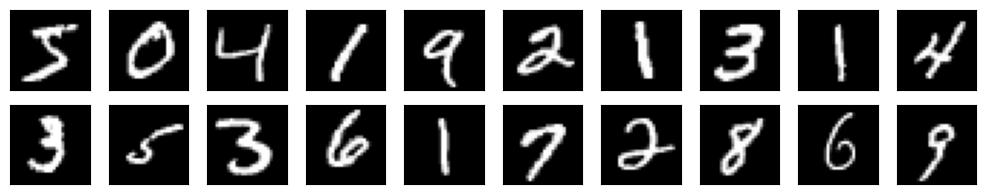

In [2]:
(x_mnist_1, t_mnist_1), (x_mnist_2, t_mnist_2) = mnist.load_data()

x_mnist = np.r_[x_mnist_1, x_mnist_2]
t_mnist = np.r_[t_mnist_1, t_mnist_2]
fig = plt.figure(figsize=(10, 10))

for i in range(20):
    x = x_mnist[i]
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()


x_mnist = x_mnist.astype("float64") / 255.
t_mnist = np.eye(N=10)[t_mnist.astype("int32").flatten()]

x_mnist = x_mnist.reshape(x_mnist.shape[0], -1)

x_train_mnist, x_test_mnist, t_train_mnist, t_test_mnist =\
    train_test_split(x_mnist, t_mnist, test_size=10000)
x_train_mnist, x_valid_mnist, t_train_mnist, t_valid_mnist =\
    train_test_split(x_train_mnist, t_train_mnist, test_size=10000)


**順伝播**(`__call__`)
\begin{align}
\mathbf{u}^{(j)} &= \mathbf{W}^{(j)T}\mathbf{h}^{(j-1)} + \mathbf{b}^{(j)}  \\
\mathbf{h}^{(j)} &= \text{function}(\mathbf{u}^{(j)})
\end{align}

**逆伝播**(`b_prop`)
\begin{equation}
\delta^{(j)} = \text{function}'(\mathbf{u}^{(j)}) \odot (\mathbf{W}^{(j+1)T} \delta^{(j+1)})
\end{equation}

**勾配の計算**(`compute_grad`)
\begin{align}
\nabla_{\mathbf{W}^{(j)}E} &= \frac{1}{N}\delta^{(j)}\mathbf{h}^{(j)T} \\
\nabla_{\mathbf{b}^{(j)}E} &= \frac{1}{N}\delta^{(j)}\mathbb{1}_N
\end{align}

In [3]:
def sigmoid(x):
    return np.exp(np.minimum(x,0))/(1+np.exp(-np.abs(x)))

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def relu(x):
    return np.maximum(x,0)

def deriv_relu(x):
    return (x>0).astype(x.dtype)

def softmax(x):
    x -= x.max(axis=1, keepdims=True)
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

def deriv_softmax(x):
    return softmax(x) * (1 - softmax(x))

def np_log(x):
    return np.log(np.clip(a=x, a_min=1e-10, a_max=1e+10))

In [4]:
# Dropoutの実装
class Dropout:

    # インスタンスの定義
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    # 順伝播メソッドの定義
    def forward(self, x, train_flg=True):
        # ランダムにニューロンを消去
        if train_flg: # 訓練時
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else: # テスト時
            return x * (1.0 - self.dropout_ratio)

    # 逆伝播メソッドの定義
    def backward(self, dout):
        return dout * self.mask

In [5]:
class Dense:
    def __init__(self, in_dim, out_dim, function, deriv_function):
        self.W = np.random.uniform(low=-np.sqrt(6/(in_dim+out_dim)), high=np.sqrt(6/(in_dim+out_dim)),size=(in_dim, out_dim)).astype("float64")
        self.b = np.zeros(out_dim).astype("float64")
        self.function = function
        self.deriv_function = deriv_function

        self.x = None
        self.u = None

        self.dW = None
        self.db = None

        self.params_idxs = np.cumsum([self.W.size, self.b.size])

    def __call__(self, x):
        self.x = x
        self.u = np.matmul(self.x, self.W) + self.b
        h = self.function(self.u)
        return h

    def b_prop(self, delta, W):
        self.delta = self.deriv_function(self.u) * np.matmul(delta, W.T)
        return self.delta

    def compute_grad(self):
        batch_size = self.delta.shape[0]

        self.dW = np.matmul(self.x.T, self.delta) / batch_size
        self.db = np.matmul(np.ones(batch_size), self.delta) / batch_size

    def get_params(self):
        return np.concatenate([self.W.ravel(), self.b], axis=0)

    def set_params(self, params):
        _W, _b = np.split(params, self.params_idxs)[:-1]
        self.W = _W.reshape(self.W.shape)
        self.b = _b

    def get_grads(self):
        return np.concatenate([self.dW.ravel(), self.db], axis=0)

**誤差関数**  

負の対数尤度（多クラス交差エントロピー）
\begin{equation}
E(\mathbf{x}, \mathbf{t}) = - \frac{1}{N} \sum^N_{i=1} \sum^K_{k=1}\mathbf{t}_{i, k} \log{\mathbf{y}_{i, k}}
\end{equation}

In [6]:
class Model:
    def __init__(self, hidden_dims, activation_functions, deriv_functions):
        self.layers = []
        for i in range(len(hidden_dims)-2):
            self.layers.append(Dense(hidden_dims[i], hidden_dims[i+1],
                                     activation_functions[i], deriv_functions[i]))
        self.layers.append(Dense(hidden_dims[-2], hidden_dims[-1],
                                 activation_functions[-1], deriv_functions[-1]))

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, delta):
        batch_size = delta.shape[0]

        for i, layer in enumerate(self.layers[::-1]):
            if i == 0:
                layer.delta = delta
                layer.compute_grad()
            else:
                delta = layer.b_prop(delta, W)
                layer.compute_grad()

            W = layer.W

    def update(self, eps=0.01):
        for layer in self.layers:
            layer.W -= eps * layer.dW
            layer.b -= eps * layer.db

In [7]:
model=Model(hidden_dims=[784,100,100,10],activation_functions=[relu,relu,softmax],deriv_functions=[deriv_relu,deriv_relu,deriv_softmax])

In [8]:
def train_mst(model, x, t, eps=0.01):
    y = model(x)

    cost = (-t * np_log(y)).sum(axis=1).mean()

    delta = y - t
    model.backward(delta)

    model.update(eps)


In [9]:
def create_batch(data, batch_size):
    num_batches, mod = divmod(data.shape[0], batch_size)
    batched_data = np.split(data[: batch_size * num_batches], num_batches)
    if mod:
        batched_data.append(data[batch_size * num_batches:])

    return batched_data

In [10]:

def train_mst(model,x,t,eps=0.01):

    y=model(x)
    cost= (-t * np_log(y)).sum(axis=1).mean()
    delta=y-t
    model.backward(delta)
    model.update(eps)
    return cost,y

In [11]:
def valid_mst(model,x,t):
    y=model(x)
    cost=(-t * np_log(y)).sum(axis=1).mean()
    return cost,y

EPOCH: 1 ,train Cost : 0.266, Valid Cost: 0.277 ,train Accuracy : 0.922 ,Valid Accuracy: 0.921
EPOCH: 2 ,train Cost : 0.215, Valid Cost: 0.237 ,train Accuracy : 0.938 ,Valid Accuracy: 0.933
EPOCH: 3 ,train Cost : 0.146, Valid Cost: 0.171 ,train Accuracy : 0.958 ,Valid Accuracy: 0.951
EPOCH: 4 ,train Cost : 0.127, Valid Cost: 0.156 ,train Accuracy : 0.963 ,Valid Accuracy: 0.955
EPOCH: 5 ,train Cost : 0.111, Valid Cost: 0.144 ,train Accuracy : 0.968 ,Valid Accuracy: 0.959
EPOCH: 6 ,train Cost : 0.099, Valid Cost: 0.133 ,train Accuracy : 0.971 ,Valid Accuracy: 0.961
EPOCH: 7 ,train Cost : 0.078, Valid Cost: 0.114 ,train Accuracy : 0.978 ,Valid Accuracy: 0.968
EPOCH: 8 ,train Cost : 0.074, Valid Cost: 0.117 ,train Accuracy : 0.979 ,Valid Accuracy: 0.967
EPOCH: 9 ,train Cost : 0.060, Valid Cost: 0.102 ,train Accuracy : 0.983 ,Valid Accuracy: 0.971
EPOCH: 10 ,train Cost : 0.054, Valid Cost: 0.097 ,train Accuracy : 0.985 ,Valid Accuracy: 0.971
EPOCH: 11 ,train Cost : 0.051, Valid Cost: 0.100 

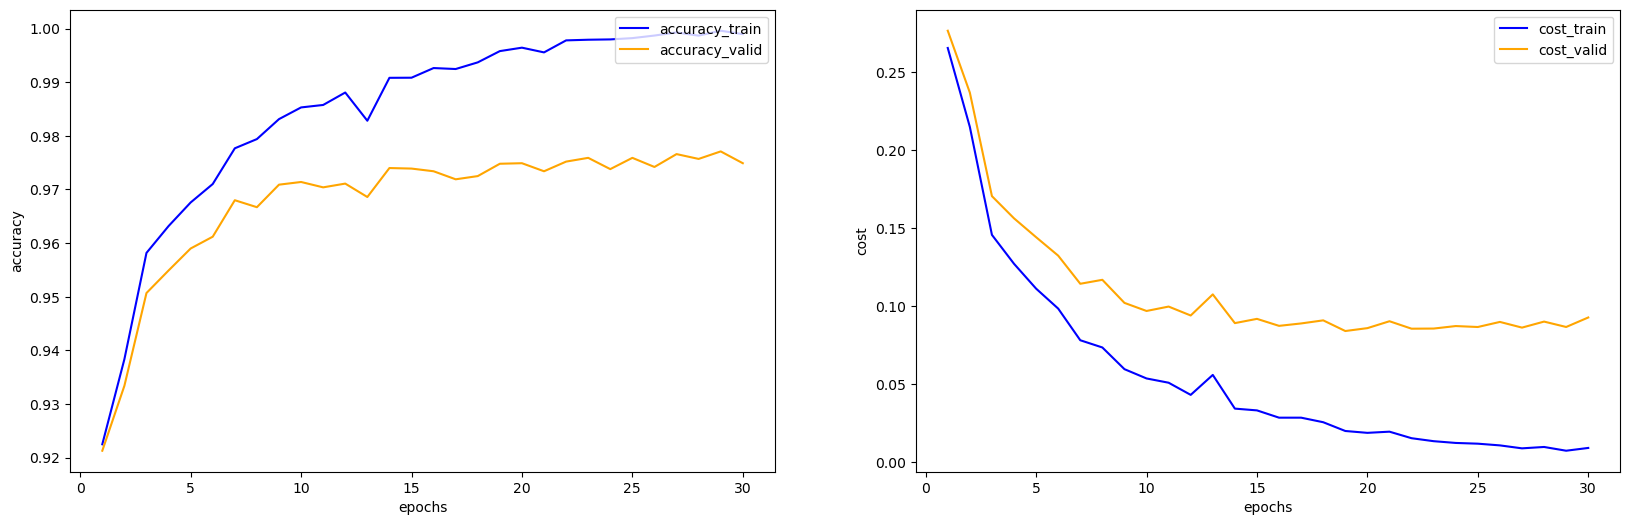

In [12]:
batch_size = 128

accuracy_train=[]
cost_train=[]
accuracy_valid=[]
cost_valid=[]

for epoch in range(30):
    x_train_mnist, t_train_mnist = shuffle(x_train_mnist, t_train_mnist)
    x_train_batch, t_train_batch = \
        create_batch(x_train_mnist, batch_size), create_batch(t_train_mnist, batch_size)

    for x, t in zip(x_train_batch, t_train_batch):
        cost = train_mst(model, x, t, eps=0.1)

    train_cost,train_pred=train_mst(model,x_train_mnist,t_train_mnist)
    train_accuracy=accuracy_score(t_train_mnist.argmax(axis=1), train_pred.argmax(axis=1))
    valid_cost, valid_pred = valid_mst(model, x_valid_mnist, t_valid_mnist)
    valid_accuracy = accuracy_score(t_valid_mnist.argmax(axis=1), valid_pred.argmax(axis=1))
    print(f"EPOCH: {epoch+1} ,train Cost : {train_cost:.3f}, Valid Cost: {valid_cost:.3f} ,train Accuracy : {train_accuracy:.3f} ,Valid Accuracy: {valid_accuracy:.3f}")
    accuracy_valid.append(valid_accuracy)
    cost_valid.append(valid_cost)
    accuracy_train.append(train_accuracy)
    cost_train.append(train_cost)

x=np.arange(1,31,1)
y1=accuracy_train
y2=cost_train
y3 = accuracy_valid
y4 = cost_valid
c1,c2= 'blue', 'orange'
l1,l2,l3,l4 = 'accuracy_train', 'cost_train','accuracy_valid','cost_valid'
xl1, xl2= 'epochs', 'epochs'
yl1, yl2= 'accuracy', 'cost'
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(x, y1, color=c1, label=l1)
ax1.plot(x,y3,color=c2,label=l3)
ax2.plot(x, y2, color=c1, label=l2)
ax2.plot(x,y4,color=c2,label=l4)
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl2)
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl2)
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')

plt.show()

In [13]:
t_pred = []
for x in x_test_mnist:
    x = x[np.newaxis, :]
    y = model(x)
    pred = y.argmax(1).tolist()
    t_pred.extend(pred)


submission = pd.Series(t_pred, name='label')


OSError: Cannot save file into a non-existent directory: '/Users'